In [3]:
# Bring your packages onto the path
import sys, os
# include directory 3 levels up 
# for 1 level up '..' 
# for 2 levels '../..'
sys.path.append(os.path.abspath(os.path.join('../../..')))

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # module for progress bar (https://pypi.org/project/tqdm/)

# Convert matplotlib figures into TikZ/PGFPlots
import tikzplotlib

# custom packages
from Models.Chaboche_Model.ChabocheModel import ChabocheModel
from Models.Chaboche_Model.ChabocheModel import chaboche_samples
from Models.Chaboche_Model.ChabocheModel import generate_model_evaluations
from Models.Chaboche_Model.ChabocheModel import chaboche_uniform_isoprob_monotonic_transform

import Surrogates.PolynomialChaosExpansion as PCE

# Model Evaluations

$\sigma(t; \, E, \sigma_{y|0}, Q_{iso}, b_{iso}, n_{iso}, D_{iso}, Q_{kin}, b_{kin} ;  \, \dot{\varepsilon}, \nu)$

## 8 Random Variables

($\nu$ if fixed to 0.3)

1. Young's Modulus: $E$

2. Initial Yield Limit: $\sigma_{y|0}$

### Isotropic Parameters

3. Isotropic Asympotote: $Q_{iso}$

4. Isotropic growth rate: $b_{iso}$

5. Isotrpic exponent: $n_{iso}$

6. Isotropic threshold: $D_{iso}$

### Kinematic Parameters

7. Kinematic Asympotote: $Q_{kin}$

8. Kinematic growth rate: $b_{kin}$



# Monotonic Loading

In [5]:
number_of_realizations = 5_000
t_min = 0
t_max = 2
delta_t = 1e-3 # time step
n_t = int((t_max-t_min)/delta_t)

max_strain = 5e-2
time_to_max_strain = 1

model = ChabocheModel('1D', 'monotonic', max_strain, time_to_max_strain)

In [ ]:
# store samples of parameters
# each row contains 1 set of parameters
SampleSpace = chaboche_samples(number_of_realizations) # [number_of_realizations, 8] matrix

# For monotonic loading
# set b_kin and Q_kin to 0
SampleSpace[:, 6] = 0 # set Q_kin to 0
SampleSpace[:, 7] = 0 # set b_kin to 0

func_evaluations = generate_model_evaluations(model, t_min, t_max, delta_t, 'implicit', SampleSpace, parallel_computation = True)

# plot solution corresponding to each set of random variable
model.stress_plot(t_min, t_max, delta_t, func_evaluations)

# Point-wise Sobol Indices

Using PCE surrogates

In [7]:
# PCE Surrogate
total_polynomial_degree = 6
number_of_random_variables = N_p = 6
polynomial_classes_of_random_variables = [PCE.Legendre]*number_of_random_variables

PCE_t_i = PCE.PCE_surrogate(total_polynomial_degree, polynomial_classes_of_random_variables, chaboche_uniform_isoprob_monotonic_transform)

# Points where Sobol indices must be computed
inspection_points = 100
I = np.linspace(10 , n_t, inspection_points, dtype=int)
T = np.linspace(0, 2, n_t+1)

# store indices
S = np.zeros((N_p, inspection_points))
S_T = np.zeros((N_p, inspection_points))

# store LOO error
LOO_error = np.zeros((inspection_points, 1))

# store variance
store_variance = np.zeros((inspection_points, 1))

print(f"Number of PCE terms: {PCE_t_i.number_of_PCE_terms}")
print(f"Number of evaluations needed (empirical estimate): {(number_of_random_variables - 1)*PCE_t_i.number_of_PCE_terms}") # (M-1)*P [Sudret]
print(f"Number of function evaluations: {func_evaluations.shape[1]}") 

for j, time_index in enumerate(tqdm(I, desc = 'Computing Indices', ncols=100)):

    X_hat = SampleSpace[:, :6]
    Y_hat = func_evaluations[time_index, :]

    _ = PCE_t_i.find_coefficients(X_hat, Y_hat)

    # store error at each t_i
    LOO_error[j] = PCE_t_i.LeaveOneOut(X_hat, Y_hat)

    # store variance at each t_i
    product_beta = PCE_t_i.beta**2
    store_variance[j] = np.sum(product_beta[1:])

    # Sobol Indices
    S_first, S_tot = PCE_t_i.Sobol_Indices()

    S[:, j] = S_first
    S_T[:, j] = S_tot

Computing Indices:   0%|                                                    | 0/100 [00:00<?, ?it/s]

Number of PCE terms: 924
Number of evaluations needed (empirical estimate): 4620
Number of function evaluations: 5000


Computing Indices: 100%|██████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


# Plot

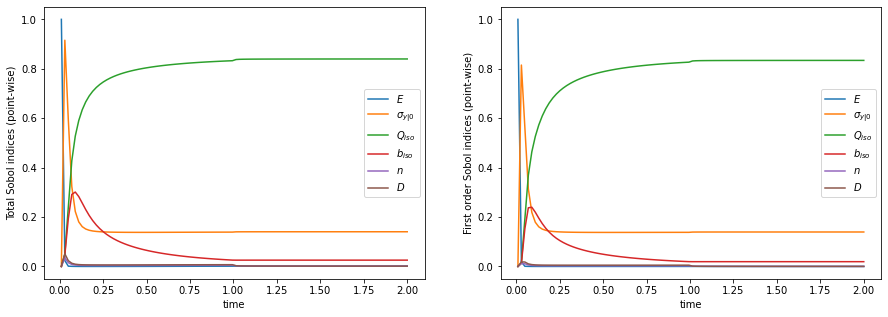

In [8]:
fig, ax = plt.subplots(1, 2,figsize=(15,5))

ax[0].plot(T[I], S_T[0,:], '-', label = r'$E$')
ax[0].plot(T[I], S_T[1,:], '-', label = r'$\sigma_{y|0}$')
ax[0].plot(T[I], S_T[2,:], '-', label = r'$Q_{iso}$')
ax[0].plot(T[I], S_T[3,:], '-', label = r'$b_{iso}$')
ax[0].plot(T[I], S_T[4,:], '-', label = r'$n$')
ax[0].plot(T[I], S_T[5,:], '-', label = r'$D$')
ax[0].legend()
ax[0].set_xlabel('time')
ax[0].set_ylabel('Total-order Sobol indices')

ax[1].plot(T[I], S[0,:], '-', label = r'$E$')
ax[1].plot(T[I], S[1,:], '-', label = r'$\sigma_{y|0}$')
ax[1].plot(T[I], S[2,:], '-', label = r'$Q_{iso}$')
ax[1].plot(T[I], S[3,:], '-', label = r'$b_{iso}$')
ax[1].plot(T[I], S[4,:], '-', label = r'$n$')
ax[1].plot(T[I], S[5,:], '-', label = r'$D$')
ax[1].legend()
ax[1].set_xlabel('time')
ax[1].set_ylabel('First-order order Sobol indices')

plt.show()

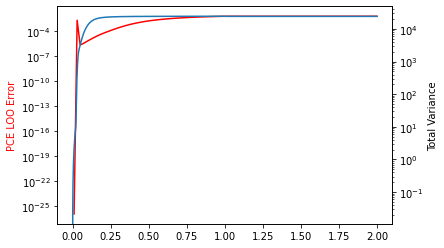

Maximum LOO error:0.577%


In [18]:
fig, ax = plt.subplots()

ax.semilogy(T[I], LOO_error,  '-', color = 'red', label = 'PCE LOO Error')
ax.set_ylabel("PCE LOO Error", color = 'red')

ax2 = ax.twinx()
ax2.semilogy(T, np.var(func_evaluations, axis=1), '-', label = 'Total Variance')
ax2.set_ylabel("Total Variance")

plt.show()

print(f"Maximum LOO error:{np.max(LOO_error)*100:.3f}%")